# Basic PUMS Analysis with OpenDP

This notebook will be a brief tutorial on doing data analysis within the OpenDP system.

We will start out by setting up our environment -- loading the necessary libraries and establishing the very basic
things we need to know before loading our data (the file path and variable names).

In [390]:
# load libraries
from opendp.trans import *
from opendp.meas import *
from opendp.core import *
from opendp.typing import *

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married", "pid"]

# TODO: Remove column headers
with open(data_path) as input_data:
    data = input_data.read()

### Properties

*TODO* OpenDP architeture description here

Let's examine how we can read and process data within a computation chain. We already have data as a string, read in
from a file.
Here are the first 5 lines of the data:

In [391]:
print('\n'.join(data.split('\n')[:6]))

59,1,9,1,0,1
31,0,1,3,17000,0
36,1,11,1,0,1
54,1,11,1,9100,1
39,0,5,3,37000,0
34,0,9,1,0,1


Now let's read this data into a computation chain and select the age column. Notice we will need to specify the columns
as integer indices. make_select_column will then give us the nth column as a particular type. In this case, giving
us the first column cast as a string:

In [392]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4, 5]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=0, T=str)
)
res = preprocessor(data)
print(type(res))
print(res)

<class 'str'>
["59", "31", "36", "54", "39", "34", "93", "69", "40", "27", "59", "31", "73", "89", "39", "51", "32", "52", "24", "48", "51", "43", "29", "44", "87", "27", "58", "32", "74", "28", "70", "35", "36", "63", "21", "29", "44", "35", "43", "59", "53", "42", "32", "50", "18", "40", "42", "52", "56", "45", "39", "28", "46", "45", "32", "22", "52", "21", "60", "77", "38", "40", "34", "48", "69", "46", "40", "26", "37", "30", "70", "42", "24", "31", "20", "33", "47", "19", "33", "66", "23", "51", "23", "47", "48", "43", "31", "47", "74", "93", "55", "29", "33", "50", "28", "29", "38", "42", "50", "77", "37", "40", "30", "19", "50", "82", "22", "63", "48", "46", "45", "37", "76", "25", "40", "34", "56", "43", "42", "22", "45", "32", "23", "19", "52", "44", "43", "34", "32", "38", "40", "82", "31", "42", "47", "66", "30", "42", "50", "26", "53", "22", "28", "25", "30", "86", "33", "62", "23", "36", "84", "29", "29", "18", "44", "61", "72", "59", "33", "51", "35", "47", "50", "30", "

Age doesn't make sense as a string for our purposes, so let's cast it to an integer:

In [393]:
# Create a chained computation
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=0, T=str)
    # Cast the column as Vec<Int>
)
chain = preprocessor >> make_cast(TI=str, TO=int) >> make_impute_constant(0)
print(chain(data)[:10])

[59, 31, 36, 54, 39, 34, 93, 69, 40, 27]


Now that we have an age column as integers and we've imputed any missing values, let's clamp the values to a defined
range so that we can quantify our sensitivity for future computations:

In [394]:
# Create a chained computation
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=0, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    make_clamp(20, 50)
)
res = preprocessor(data)
print(res[:10])

[50, 31, 36, 50, 39, 34, 50, 50, 40, 27]


Notice the first element was 0, but the clamp changed it to 20. Similarly, the second element has changed from 59 to 50.

Time to compute our first aggregate statistic. Suppose we want to know the sum of the ages in our dataset.
We can add one more step to our previous computation chain: make_bounded_sum. This will take the result of make_clamp,
and calculate the sum over the domain [20, 50].

In [395]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=0, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    # Clamp age values
    make_clamp(20, 50) >>
    make_bounded_sum(lower=20, upper=50)
)

res = preprocessor(data)
print(res)


39650


We may be more interested in the mean age of the data. Then we can take the result of clamp and call
make_bounded_mean over the same domain.

Our bounded mean age is:

In [396]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    # TODO: how to remove column headers?
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=0, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=float) >>
    # Impute missing values to 0
    make_impute_constant(0.) >>
    # Clamp age values
    make_clamp(20., 50.)
    # make_bounded_mean(lower=1000., upper=1_000_000., n=100, T=float)
    # make_base_laplace(scale=1.0)

)

# TOOO: chain these into one process. Currently getting domain mismatch error
# Mike: Once you do the count, you could pull the count before the mean, and then use the count as an input to resize.
res = preprocessor(data)
mean_process = make_bounded_mean(20., 50., n=1000, T=float)
res = mean_process(res)
print(res)

39.65


In [397]:
query = make_bounded_mean(lower=0., upper=10., n=9)
print("Bounded mean: ", query([float(x) for x in range(0,10)]))


Bounded mean:  5.0


Privatizing sums
(TODO: Explain geometric mechanism and how it privatizes the sum)

preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=0, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    # Clamp age values
    make_clamp(20, 50) >>
    make_bounded_sum(lower=20, upper=50) >>
    make_base_geometric(scale=1.0)

)

res = preprocessor(data)
print(res)



Privatizing histograms

Let's take a look at the third column, which contains education level.

In [405]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=2, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    make_count_by_categories(categories=list(range(1,20)), MO=L1Distance[float])
)

res = preprocessor(data)
print("Educational level counts:\n", res)

Educational level counts:
 [33, 14, 38, 17, 24, 21, 31, 51, 201, 60, 165, 76, 178, 54, 24, 13, 0, 0, 0, 0]


<BarContainer object of 20 artists>

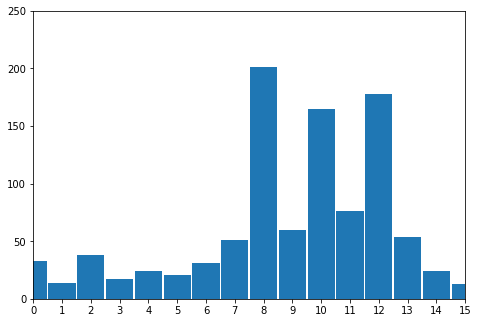

In [428]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.ylim([0,250])
tick_spacing = 1.
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.xlim(0,15)
ax.bar(list(range(0, len(res))), res, width=.95, label='True Value')

In [ ]:
What about a private histogram?

What about a private histogram?

In [399]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=2, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    make_count_by_categories(categories=list(range(1,20)), MO=L1Distance[float]) # >>
    # make_base_geometric(scale=1., bounds=(0,201), D="VectorDomain<AllDomain<i32>>")
)

# TODO: include this in preprocessor once PR is merged that makes histogram return VectorDomain instead of SizedDomain
res = preprocessor(data)
res = make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])(res)

print("Private educational level counts:\n", res)



Private educational level counts:
 [30, 14, 38, 17, 23, 20, 31, 49, 201, 62, 165, 77, 177, 56, 24, 15, -1, 1, 0, -1]


Privatizing counts:

Sometimes you will want to make a DP release of the total number of elements in a data set. For example: How many rows
does our data set have? Below, we will use `make_count` to calculate this number, and `make_base_geometric` to
privatize the value.

In [401]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=2, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    make_count(TIA=int, TO=int) >>
    make_base_geometric(scale=1., D=AllDomain[int])
)

res = preprocessor(data)

print("Private count:\t", res)

Private count:	 1000


In [235]:
with open(data_path) as input_data:
    data = input_data.read()

In [236]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=4, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=int) >>
    # Impute missing values to 0
    make_impute_constant(0) >>
    # Clamp age values
    make_clamp(1000, 1_000_000) >>
    make_bounded_sum(lower=1000, upper=1_000_000)
    # make_base_laplace(scale=1.0)

)


res = preprocessor(data)
print("Income column sum: ", res)


Income column sum:  33912224


In [243]:
preprocessor = (
    # Convert data into Vec<Vec<String>>
    # TODO: how to remove column headers?
    make_split_dataframe(separator=",", col_names=[0, 1, 2, 3, 4]) >>
    # Selects a column of df, Vec<str>
    make_select_column(key=4, T=str) >>
    # Cast the column as Vec<Int>
    make_cast(TI=str, TO=float) >>
    # Impute missing values to 0
    make_impute_constant(0.) >>
    # Clamp age values
    make_clamp(1000., 1_000_000.)
    # make_bounded_mean(lower=1000., upper=1_000_000., n=100, T=float)
    # make_base_laplace(scale=1.0)

)

# TOOO: chain these into one process. Currently getting domain mismatch error
res = preprocessor(data)
mean_process = make_bounded_mean(1000., 1_000_000., n=10, T=float)
res = mean_process(res)
print("Income bounded mean: ", res)

Income bounded mean:  3450622.4


In [ ]:
query = make_bounded_mean(lower=0., upper=10., n=9)
print("Bounded mean: ", query([float(x) for x in range(0,10)]))

In [ ]:
query = make_bounded_mean(lower=0., upper=10., n=9)
print("Bounded mean: ", query([float(x) for x in range(0,10)]))